<a href="https://colab.research.google.com/github/SainRigo/Prune_mobile_10/blob/main/Copy_of_Mobilenet_plumdatraset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os


# we access the file where are store our images

print(os.listdir("/content/drive/MyDrive/plum_data/plum_data/"))

['Good', 'Bad']


In [3]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, AveragePooling2D
from tensorflow.keras.layers import Concatenate , Flatten , Dense , Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications import DenseNet121 , VGG16
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import normalize
from tensorflow.keras.optimizers import Adam

In [4]:


defective_path_l = os.listdir('/content/drive/MyDrive/plum_data/plum_data/Bad/')
good_path_l = os.listdir('/content/drive/MyDrive/plum_data/plum_data/Good/')
len(defective_path_l)+ len(good_path_l)

4507

In [5]:
Image_data = []        # in this list will be append all the images read
Labels_image = []      # in this list will be append the label (statu) in the same oder of each image


# here is the path to the infected images.
# we used a for loop with a step 2 to just read half of the images.

defective_path = "/content/drive/MyDrive/plum_data/plum_data/Bad/"
defective_path_l.sort()

for i in range(0, len(defective_path_l), 2):
    image_path = os.path.join(defective_path, defective_path_l[i])
    images_pil = cv2.imread(image_path)
    image_array = Image.fromarray(images_pil , 'RGB')                     # read of image as RGB
    resize_img = image_array.resize((224 , 224))                          # resizing of image
    Image_data.append(np.array(resize_img))
    Labels_image.append(1)                                                # label on the image


# here we look for the total number of images read and the number of labels in our list
len(Image_data), len(Labels_image)

(1877, 1877)

In [6]:
good_path = "/content/drive/MyDrive/plum_data/plum_data/Good/"
good_path_l.sort()

for j in range(0, len(good_path_l), 2):
    image_pathu = os.path.join(good_path, good_path_l[j])
    images_pilu = cv2.imread(image_pathu)
    image_arrayu = Image.fromarray(images_pilu, 'RGB')
    resize_imgu = image_arrayu.resize((224 , 224))
    Image_data.append(np.array(resize_imgu))
    Labels_image.append(0)

# we labeled the uninfected cells as 0


# here is the total images for the study, whych is exactly of the half of the total images
len(Image_data), len(Labels_image)

(2254, 2254)

In [7]:
cells = np.array(Image_data)
labels = np.array(Labels_image)

In [8]:
print('Shape of Cells : {} , shape of labels : {}'.format(cells.shape , labels.shape))

Shape of Cells : (2254, 224, 224, 3) , shape of labels : (2254,)


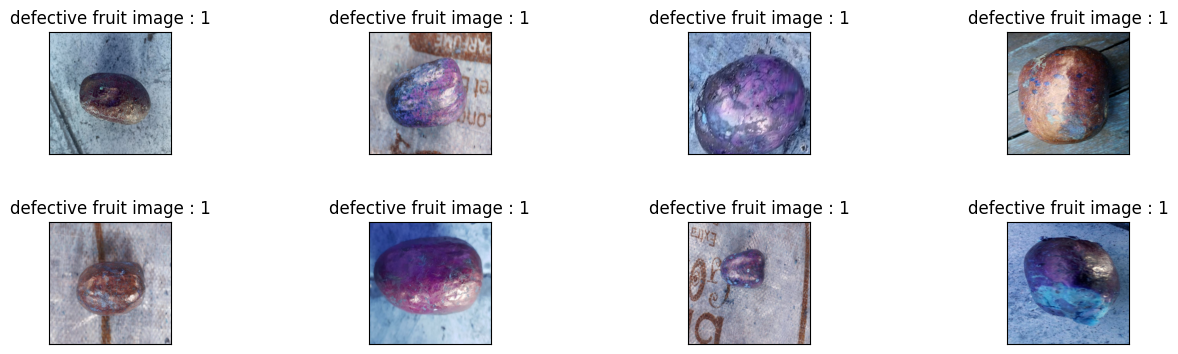

In [9]:
plt.figure(1 , figsize = (15 , 9))
n = 0
for i in range(8):
    n += 1
    r = np.random.randint(0 , cells.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.56, wspace = 0.56)
    plt.imshow(cells[r[0]])
    plt.title('{} : {}'.format('defective fruit image' if labels[r[0]] == 1 else 'good fruit image' ,
                               labels[r[0]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

In [10]:

n = np.arange(cells.shape[0])
np.random.shuffle(n)
cells = cells[n]
labels = labels[n]

In [11]:
cells = cells.astype(np.float32)/255.00
labels = labels.astype(np.int32)

In [12]:
# we split the data into train, test and validation set

from sklearn.model_selection import train_test_split

train_x , X , train_y , Y = train_test_split(cells , labels, test_size = 0.3 , random_state = 111)

test_x, valid_x, test_y, valid_y = train_test_split(X,Y, test_size = 0.5, random_state= 111)

In [13]:
print('Proportion of the data:')
print("train set: X_train: {}, Y_train: {}".format(train_x.shape, train_y.shape))
print('%===============================================%')
print('Validation set: x_validation: {}, y_validation: {}'.format(valid_x.shape, valid_y.shape))
print('%===============================================%')
print("test shape: x_test: {}, y_test: {}".format(test_x.shape, test_y.shape))

Proportion of the data:
train set: X_train: (1577, 224, 224, 3), Y_train: (1577,)
%===============================================%
Validation set: x_validation: (339, 224, 224, 3), y_validation: (339,)
%===============================================%
test shape: x_test: (338, 224, 224, 3), y_test: (338,)


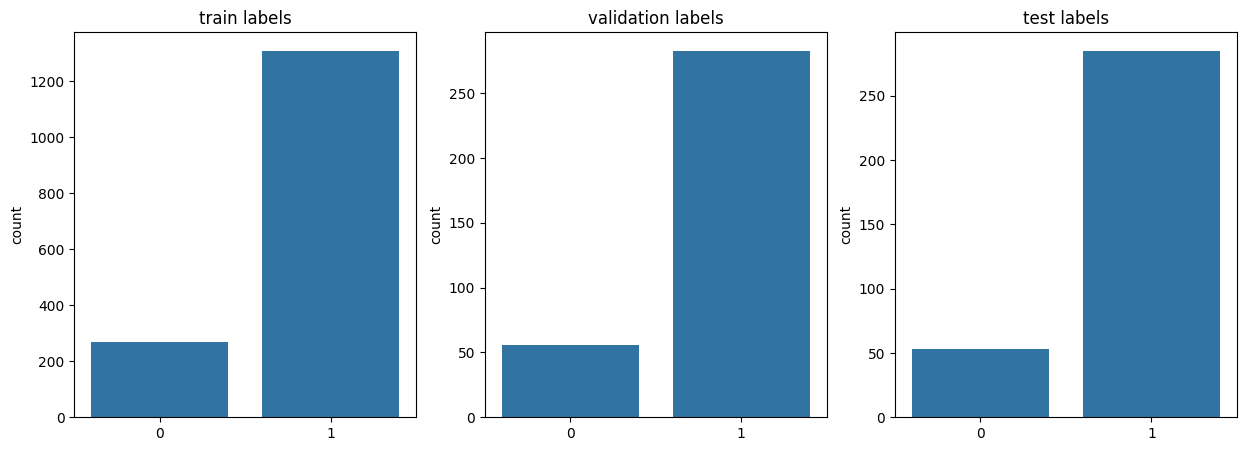

In [14]:
plt.figure(1 , figsize = (15 ,5))
n = 0
for z , j in zip([train_y , valid_y,  test_y] , ['train labels','validation labels', 'test labels']):
    n += 1
    plt.subplot(1 , 3  , n)
    sns.countplot(x = z )
    plt.title(j)
plt.show()

In [15]:
!pip install tensorflow_model_optimization

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 4.5 MB/s eta 0:00:00


In [16]:
import tensorflow_model_optimization

In [17]:
import tensorflow_model_optimization
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow_model_optimization.sparsity import keras as sparsity

def mobilenet(input_shape, n_classes):
    def mobilenet_block(x, f, s=1):
        x = DepthwiseConv2D(3, strides=s, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)

        x = Conv2D(f, 1, strides=1, padding='same')(x)
        x = BatchNormalization()(x)
        x = ReLU()(x)
        return x

    input = Input(input_shape)

    x = Conv2D(32, 3, strides=2, padding='same')(input)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    x = mobilenet_block(x, 64)
    x = mobilenet_block(x, 128, 2)
    x = mobilenet_block(x, 128)

    x = mobilenet_block(x, 256, 2)
    x = mobilenet_block(x, 256)

    x = mobilenet_block(x, 512, 2)
    for _ in range(5):
        x = mobilenet_block(x, 512)

    x = mobilenet_block(x, 1024, 2)
    x = mobilenet_block(x, 1024)

    x = GlobalAvgPool2D()(x)

    output = Dense(n_classes, activation='softmax')(x)

    model = Model(input, output)
    return model

n_classes = 2  # Replace with the actual number of classes in your classification problem
input_shape = (224, 224, 3)

# Create the model instance using the mobilenet function
model = mobilenet(input_shape, n_classes)

# Compile the model
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.01),
              metrics=['accuracy'])

# Define the pruning parameters
pruning_params = {
    'pruning_schedule': sparsity.ConstantSparsity(target_sparsity=0.10, begin_step=0, end_step=-1, frequency=100)
}

# Apply pruning to the model
pruned_model = tf.keras.models.clone_model(model)
pruned_model = sparsity.prune_low_magnitude(pruned_model, **pruning_params)
pruned_model.build(input_shape)  # Rebuild the model after pruning

# Compile the pruned model
pruned_model.compile(loss=BinaryCrossentropy(),
                     optimizer=Adam(learning_rate=0.01),
                     metrics=['accuracy'])

pruned_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 prune_low_magnitude_conv2d  (None, 112, 112, 32)      1762      
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_batch_  (None, 112, 112, 32)      129       
 normalization (PruneLowMag                                      
 nitude)                                                         
                                                                 
 prune_low_magnitude_re_lu   (None, 112, 112, 32)      1         
 (PruneLowMagnitude)                                             
                                                                 
 prune_low_magnitude_depthw  (None, 112, 112, 32)      321   

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

# Learning rate is also a hyperparameter
model.compile(loss=BinaryCrossentropy(),
              optimizer=Adam(learning_rate=0.01), metrics=['accuracy'])

In [19]:


import tensorflow as tf

In [20]:
# Resize the training and validation data
train_x_resized = tf.image.resize(train_x, size=(224, 224))
valid_x_resized = tf.image.resize(valid_x, size=(224, 224))

In [21]:
import tensorflow as tf

# Convert labels to one-hot encoded format
train_y_one_hot = tf.keras.utils.to_categorical(train_y, num_classes=n_classes)
valid_y_one_hot = tf.keras.utils.to_categorical(valid_y, num_classes=n_classes)

# Compile the model
pruned_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define the UpdatePruningStep callback
callbacks = [
    sparsity.UpdatePruningStep()
]

# Train the model with the one-hot encoded labels and include the UpdatePruningStep callback
history = pruned_model.fit(
    train_x_resized,
    train_y_one_hot,
    epochs=40,
    validation_data=(valid_x_resized, valid_y_one_hot),
    callbacks=callbacks)

Epoch 1/40
50/50 [==============================] - 378s 7s/step - loss: 0.4574 - accuracy: 0.8110 - val_loss: 0.8585 - val_accuracy: 0.1652
Epoch 2/40
50/50 [==============================] - 318s 6s/step - loss: 0.3379 - accuracy: 0.8561 - val_loss: 0.9704 - val_accuracy: 0.1652
Epoch 3/40
50/50 [==============================] - 320s 6s/step - loss: 0.3081 - accuracy: 0.8548 - val_loss: 0.7192 - val_accuracy: 0.1652
Epoch 4/40
50/50 [==============================] - 312s 6s/step - loss: 0.2726 - accuracy: 0.8744 - val_loss: 0.6786 - val_accuracy: 0.8348
Epoch 5/40
50/50 [==============================] - 322s 6s/step - loss: 0.2753 - accuracy: 0.8782 - val_loss: 0.5551 - val_accuracy: 0.8348
Epoch 6/40
50/50 [==============================] - 313s 6s/step - loss: 0.2455 - accuracy: 0.8903 - val_loss: 0.5079 - val_accuracy: 0.8348
Epoch 7/40
50/50 [==============================] - 306s 6s/step - loss: 0.2428 - accuracy: 0.8897 - val_loss: 0.4870 - val_accuracy: 0.8348
Epoch 8/40
50

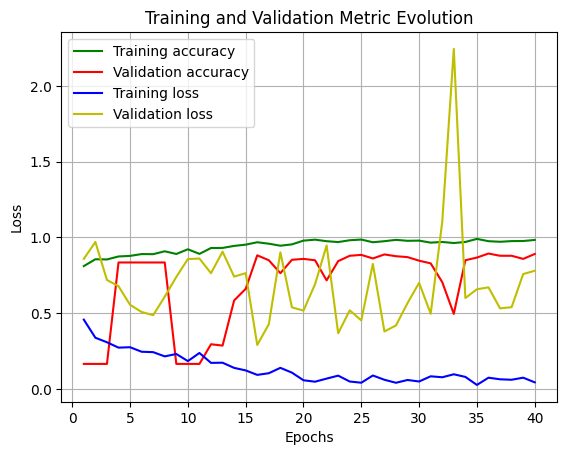

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'y', label='Validation loss')

plt.title('Training and Validation Metric Evolution')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show()

In [23]:
import numpy as np

# Make predictions on validation data
predictions = pruned_model.predict(valid_x_resized)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate metrics
num_correct = np.sum(predicted_classes == np.argmax(valid_y_one_hot, axis=1))
accuracy = num_correct / valid_y_one_hot.shape[0]

true_positives = np.sum(np.logical_and(predicted_classes == 1, np.argmax(valid_y_one_hot, axis=1) == 1))
false_positives = np.sum(np.logical_and(predicted_classes == 1, np.argmax(valid_y_one_hot, axis=1) != 1))
false_negatives = np.sum(np.logical_and(predicted_classes != 1, np.argmax(valid_y_one_hot, axis=1) == 1))

precision = true_positives / (true_positives + false_positives)
recall = true_positives / (true_positives + false_negatives)
f1 = 2 * (precision * recall) / (precision + recall)

# Print results
print("Accuracy: {:.4f}".format(accuracy))
print("Precision: {:.4f}".format(precision))
print("Recall: {:.4f}".format(recall))
print("F1 Score: {:.4f}".format(f1))

11/11 [==============================] - 19s 2s/step
Accuracy: 0.8909
Precision: 0.8968
Recall: 0.9823
F1 Score: 0.9376


In [24]:
from sklearn.metrics import accuracy_score

# Make predictions on validation data
predictions = pruned_model.predict(valid_x_resized)
predicted_classes = np.argmax(predictions, axis=1)

# Convert true labels to class indices
true_classes = np.argmax(valid_y_one_hot, axis=1)

# Calculate accuracy
accuracy = accuracy_score(true_classes, predicted_classes)

# Print accuracy
print("Accuracy:", accuracy)

11/11 [==============================] - 16s 1s/step
Accuracy: 0.8908554572271387


In [25]:
model.save('mobilenet.h1')